In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

# Choose which network you're running

In [2]:
args = []

In [3]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'
chckpt = 50
args.append((PNetClass, pnet_name, p_layers, chckpt))

In [4]:
from pbranchednetwork_conv345 import PBranchedNetwork_Conv345SeparateHP
PNetClass = PBranchedNetwork_Conv345SeparateHP
pnet_name = 'conv345'
p_layers = 'Layers 3-5'
chckpt = 5
args.append((PNetClass, pnet_name, p_layers, chckpt))

In [5]:
from pbranchednetwork_conv3 import PBranchedNetwork_Conv3SeparateHP
PNetClass = PBranchedNetwork_Conv3SeparateHP
pnet_name = 'conv3'
p_layers = 'Layer 3'
chckpt = 5
args.append((PNetClass, pnet_name, p_layers, chckpt))

# Parameters

In [5]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'

In [6]:
import os

In [7]:
os.listdir(engram_dir)

['figures',
 'training_dataset_random_order.hdf5',
 'cgrams_for_noise_robustness_analysis',
 'balloon',
 'networks_2022_weights.pt',
 '.DS_Store',
 'small_cleansounds.hdf5',
 'tensorboard',
 'PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy',
 'PsychophysicsWord2018x_not_resampled.hdf5',
 'PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy',
 'PsychophysicsWord2017W_net_performance.p',
 'activations',
 'checkpoints',
 'PsychophysicsWord2017W_not_resampled.hdf5',
 'pickles']

In [5]:
fig_dir = f'{engram_dir}figures/'
pickle_dir = f'{engram_dir}pickles/'

In [6]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'

Device: cuda:0


# Helper functions

In [7]:
def load_pnet(PNetClass, pnet_name, chckpt):
    net = BranchedNetwork()
    net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
        map_location='cpu'
        ))
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [8]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

# Load PsychoPhysics Dataset

In [9]:
f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [10]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [11]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [12]:
with open(f"{engram_dir}PsychophysicsWord2017W_net_performance.p", 'rb') as f:
    net_mistakes = pickle.load(f)['net_mistakes']

In [13]:
def getPsychophysics2017WCleanCochleagrams():
    
    cochleagrams_clean = []
   
    cochleagrams = []
    for batch_ii in range(0,15300,100):
        hdf5_path = '/mnt/smb/locker/issa-locker/users/Erica/cgrams_for_noise_robustness_analysis/PsychophysicsWord2017W_clean/batch_'+str(batch_ii)+'_to_'+str(batch_ii+100)+'.hdf5'
        with h5py.File(hdf5_path, 'r') as f_in:
            cochleagrams += list(f_in['data'])

    return cochleagrams
clean_in = getPsychophysics2017WCleanCochleagrams()

In [14]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [15]:
bg = []
for _bg in f_metadata['bg']:
    bg.append(str(_bg, 'utf-8'))
bg = np.array(bg)

In [16]:
snr = []
for _snr in f_metadata['snr']:
    _snr = str(_snr, 'utf-8')
    if 'inf' in _snr:
        _snr = np.inf
    elif 'neg' in _snr:
        if '3' in _snr:
            _snr = -3
        elif '6' in _snr:
            _snr = -6
        elif '9' in _snr:
            _snr = -9
        else:
            raise ValueError('Not found')
    else:
        if '0' in _snr:
            _snr = 0
        elif '3' in _snr:
            _snr = 3
        else:
            raise ValueError('Not found')
    snr.append(_snr)
snr = np.array(snr)

In [17]:
orig_dset = []
for _orig_dset in f_metadata['orig_dset']:
    _orig_dset = str(_orig_dset, 'utf-8')
    _orig_dset = 'WSJ' if 'WSJ' in _orig_dset else 'Timit'
    orig_dset.append(_orig_dset)
orig_dset = np.array(orig_dset)

# Plot Function

In [18]:
def eval_acc(
    pnet, bg_type='n/a',
    exclude_timit=True, exclude_correct=True, exclude_incorrect=False
    ):
    
    bg_idxs = bg==bg_type
    if exclude_timit:
        bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
    if exclude_incorrect:
        net_corrects = np.logical_not(net_mistakes)
        bg_idxs = np.logical_and(bg_idxs, net_corrects)
    if exclude_correct:
        bg_idxs = np.logical_and(bg_idxs, net_mistakes)

    timesteps = []
    accs = []
    snrs = []

    n_timesteps = 5
    for snr_type in np.unique(snr):
        dset_idxs = np.logical_and(bg_idxs, snr==snr_type)
        dset_idxs = np.argwhere(dset_idxs).squeeze()
        for idx in dset_idxs:
            label = labels[idx]
            _input = torch.tensor(f_in['data'][idx].reshape((1, 1, 164, 400)))
            _input = _input.to(DEVICE)
            pnet.reset()
            with torch.no_grad():
                for j in range(n_timesteps):
                    _input = _input if j == 0 else None
                    outputs, _ = pnet(_input)
                    output = outputs.max(-1)[1].item()
                    timesteps.append(j)
                    accs.append(int((output == label).item()))
                    snrs.append(snr_type)

    df = pd.DataFrame({
        'Timesteps': timesteps,
        'Accuracy': accs,
        'SNR': snrs
    })
    return timesteps, accs, snrs, df

# Background noises, incorrect dset

In [19]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [20]:
exclude_timit = True
exclude_correct = True
exclude_incorrect = False
dset_name = 'incorrects'
eval_bgs = ['AudScene'] # np.unique(bg)

Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


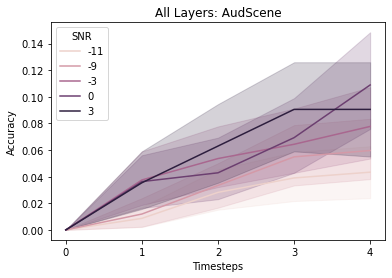

In [21]:
for arg in args:
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    for _bg_type in eval_bgs:
        timesteps, accs, snrs, df = eval_acc(
            pnet, bg_type=_bg_type,
            exclude_timit=exclude_timit,
            exclude_correct=exclude_correct,
            exclude_incorrect=exclude_incorrect
            )
        plt.figure()
        hue = None if _bg_type == 'n/a' else 'SNR'
        g = sns.lineplot(
            x='Timesteps', y='Accuracy',
            hue=hue, data=df
            )
        plt.title(f'{p_layers}: {_bg_type}')
        plt.xticks([0, 1, 2, 3, 4])
        plt.legend(title='SNR', labels=[-11, -9, -3, 0, 3])
        if _bg_type == 'n/a':
            _bg_type = 'None'
        with open(pickle_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.p', 'wb') as f:
            pickle.dump(df, f)
        plt.savefig(fig_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.png', dpi=300)
        plt.show(g)

# Background noises, correct dset

In [22]:
exclude_timit = True
exclude_correct = False
exclude_incorrect = True
dset_name = 'corrects'
eval_bgs = ['AudScene', 'Babble8Spkr'] # np.unique(bg)

Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


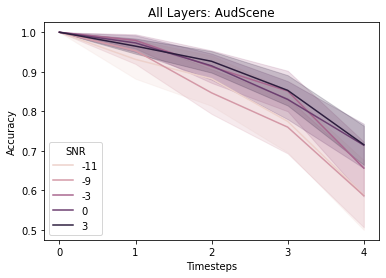

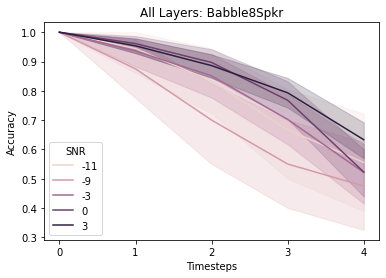

In [23]:
for arg in args:
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    for _bg_type in eval_bgs:
        timesteps, accs, snrs, df = eval_acc(
            pnet, bg_type=_bg_type,
            exclude_timit=exclude_timit,
            exclude_correct=exclude_correct,
            exclude_incorrect=exclude_incorrect
            )
        plt.figure()
        hue = None if _bg_type == 'n/a' else 'SNR'
        g = sns.lineplot(
            x='Timesteps', y='Accuracy',
            hue=hue, data=df
            )
        plt.title(f'{p_layers}: {_bg_type}')
        plt.xticks([0, 1, 2, 3, 4])
        plt.legend(title='SNR', labels=[-11, -9, -3, 0, 3])
        if _bg_type == 'n/a':
            _bg_type = 'None'
        with open(pickle_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.p', 'wb') as f:
            pickle.dump(df, f)
        plt.savefig(fig_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.png', dpi=300)
        plt.show(g)

# Background noises, all

In [24]:
exclude_timit = True
exclude_correct = False
exclude_incorrect = False
dset_name = 'all'
eval_bgs = ['AudScene', 'Babble8Spkr'] # np.unique(bg)

Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010


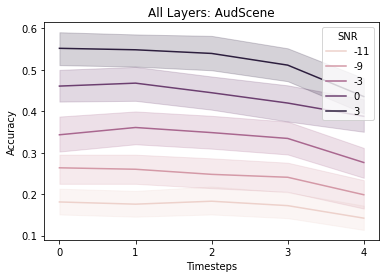

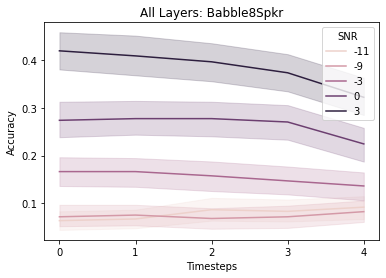

In [25]:
for arg in args:
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    for _bg_type in eval_bgs:
        timesteps, accs, snrs, df = eval_acc(
            pnet, bg_type=_bg_type,
            exclude_timit=exclude_timit,
            exclude_correct=exclude_correct,
            exclude_incorrect=exclude_incorrect
            )
        plt.figure()
        hue = None if _bg_type == 'n/a' else 'SNR'
        g = sns.lineplot(
            x='Timesteps', y='Accuracy',
            hue=hue, data=df
            )
        plt.title(f'{p_layers}: {_bg_type}')
        plt.xticks([0, 1, 2, 3, 4])
        plt.legend(title='SNR', labels=[-11, -9, -3, 0, 3])
        if _bg_type == 'n/a':
            _bg_type = 'None'
        with open(pickle_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.p', 'wb') as f:
            pickle.dump(df, f)
        plt.savefig(fig_dir + f'acc_{dset_name}_{pnet_name}_{_bg_type}.png', dpi=300)
        plt.show(g)